#### imports

In [92]:
from sklearn.svm import SVC
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import uniform

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Task 1

Train a decision tree model and perform hyperparameter search for the moons dataset. \
a. Generate the dataset using the function make_moons(n_samples=10000, noise=0.4). \
b. Split it into training and test sets using the function train_test_split().\
c. Use cross-validation search (GridSearchCV, RandomizedSearchCV) to search for hyperparameters of the DecisionTreeClassifier model. In particular, try different values for the max_leaf_nodes parameter..

## model training without hyperparameter tuning



- spilitting the data

In [43]:
X, y = make_moons(n_samples=10000, noise=0.4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle=True)

- model training + counting accuracy

In [61]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(accuracy, 2)}')

Accuracy: 0.81


- decision boundary

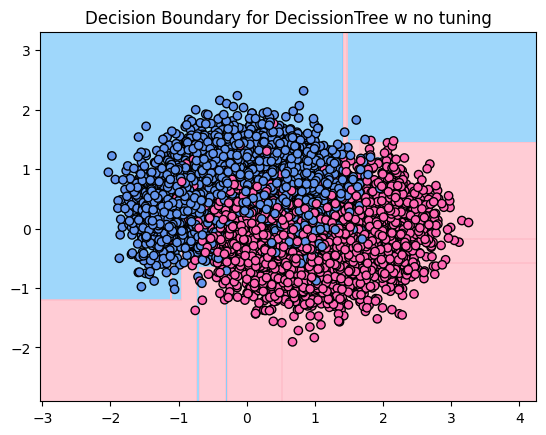

In [45]:
# extracting min and max values of each feature
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
# grid for plotting values in between min and max of each feature
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# plot
plt.contourf(xx, yy, Z, alpha=0.8,
             cmap=ListedColormap(('lightskyblue', 'pink')))
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o',
            cmap=ListedColormap(('cornflowerblue', 'hotpink')))
plt.title('Decision Boundary for DecissionTree w no tuning')
plt.show()

## applying GridSearchCV

- model training

In [46]:
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10],
    'max_leaf_nodes': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

gs_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, cv=5)
gs_cv.fit(X_train, y_train)

gs_cv.best_estimator_

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


DecisionTreeClassifier(max_leaf_nodes=20, random_state=42)

In [47]:
gs_cv.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_leaf_nodes': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

- predicting + counting accuracy

In [60]:
y_pred = gs_cv.predict(X_test)
g_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy w GridSearchCV: {round(g_accuracy, 2)}')

Accuracy w GridSearchCV: 0.86


- decision boundary

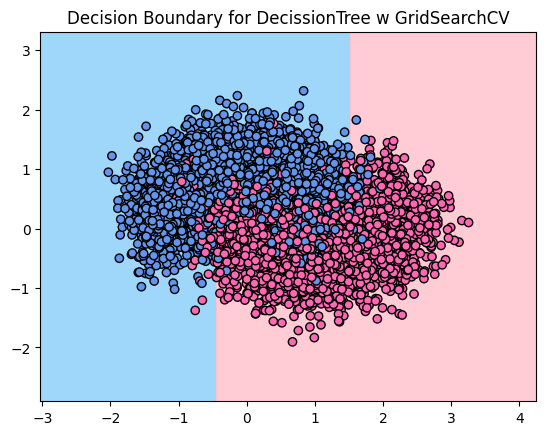

In [50]:
Z = gs_cv.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# plot
plt.contourf(xx, yy, Z, alpha=0.8,
             cmap=ListedColormap(('lightskyblue', 'pink')))
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o',
            cmap=ListedColormap(('cornflowerblue', 'hotpink')))
plt.title('Decision Boundary for DecissionTree w GridSearchCV')
plt.show()

## applying RandomizedSearchCV

- model training

In [51]:
rs_cv = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params, cv=5)
rs_cv.fit(X_train, y_train)

rs_cv.best_estimator_

DecisionTreeClassifier(max_depth=10, max_leaf_nodes=20, min_samples_split=5,
                       random_state=42)

In [52]:
rs_cv.best_params_

{'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 20,
 'max_depth': 10,
 'criterion': 'gini'}

- predicting + counting accuracy

In [59]:
y_pred = rs_cv.predict(X_test)
r_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy w RandomizedSearchCV: {round(r_accuracy, 2)}')

Accuracy w RandomizedSearchCV: 0.86


- decision boundary

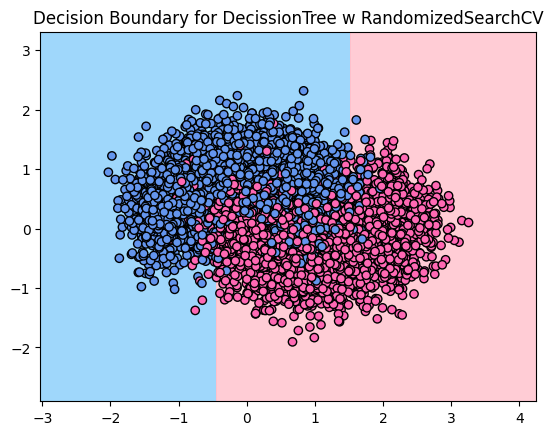

In [56]:
Z = rs_cv.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# plot
plt.contourf(xx, yy, Z, alpha=0.8,
             cmap=ListedColormap(('lightskyblue', 'pink')))
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o',
            cmap=ListedColormap(('cornflowerblue', 'hotpink')))
plt.title('Decision Boundary for DecissionTree w RandomizedSearchCV')
plt.show()

## results

- accuracy

In [58]:
print(f'No tuning accuracy:      {round(accuracy, 2)}')
print(f'With GridSearchCV:       {round(g_accuracy, 2)}')
print(f'With RandomizedSearchCV: {round(r_accuracy, 2)}')

No tuning accuracy:      0.81
With GridSearchCV:       0.86
With RandomizedSearchCV: 0.86


Let's compare all the results by building ROC-AUC curves



In [62]:
y_prob_tree = tree.predict_proba(X_test)[:, 1]
y_prob_gs_cv = gs_cv.predict_proba(X_test)[:, 1]
y_prob_rs_cv = rs_cv.predict_proba(X_test)[:, 1]

# roc-curve
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_prob_tree)
fpr_gs_cv, tpr_gs_cv, _ = roc_curve(y_test, y_prob_gs_cv)
fpr_rs_cv, tpr_rs_cv, _ = roc_curve(y_test, y_prob_rs_cv)

# area under the curve
auc_tree = auc(fpr_tree, tpr_tree)
auc_gs_cv = auc(fpr_gs_cv, tpr_gs_cv)
auc_rs_cv = auc(fpr_rs_cv, tpr_rs_cv)

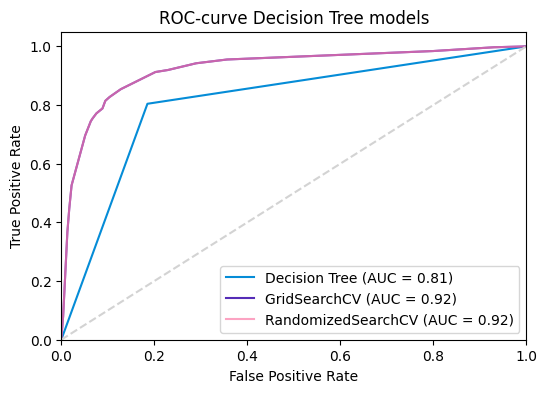

In [108]:
plt.figure(figsize=(6, 4))

plt.plot(fpr_tree, tpr_tree, label=f'Decision Tree (AUC = {auc_tree:.2f})', color='#058cd7')
plt.plot(fpr_gs_cv, tpr_gs_cv, label=f'GridSearchCV (AUC = {auc_gs_cv:.2f})', color='#552cb7')
plt.plot(fpr_rs_cv, tpr_rs_cv, label=f'RandomizedSearchCV (AUC = {auc_rs_cv:.2f})', color='#fb7da8', alpha=0.7)

plt.plot([0, 1], [0, 1], linestyle='--', color='lightgray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve Decision Tree models')
plt.legend(loc="lower right")
plt.show()

As we can see, both GridSearchCV and RandomizedSearchCV are the same, probably because of quite simple model.

# Task 2

a. Load the MNIST dataset and split it into training, validation, and test sets (for example, 50,000 / 10,000 / 10,000).\
b. Train different classification models (Random Forest classifier, Logistic Regression, SVM).\
c. Then, combine them using the voting method.\
d. Train a new model using the outputs of the previous models on the validation set (these will be the new features and the new training set for the model). Test the resulting pipeline on the training set. This method of combining models is called stacking.  

In [69]:
mnist = fetch_openml('mnist_784', version=1, cache=True)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

X_train = X[:50000]
y_train = y[:50000]
X_test = X[60000:]
y_test = y[60000:]

X_val = X[50000:60000]
y_val = y[50000:60000]

## exploring the data

In [32]:
df = pd.DataFrame(X_train)
df['num'] = y_train
df.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,num
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [33]:
df.shape

(50000, 785)

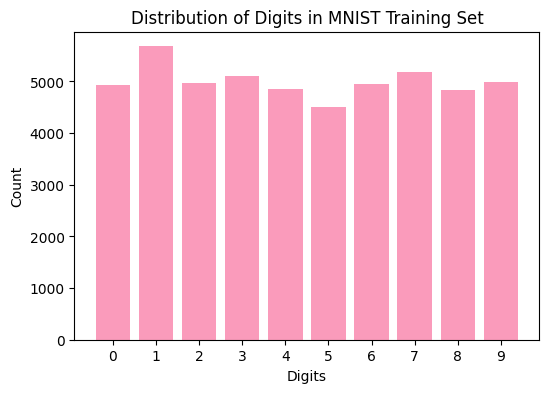

In [100]:
num, c = np.unique(y_train, return_counts=True)

plt.figure(figsize=(6, 4))
plt.bar(num, c, color='#fa9bbb')
plt.xlabel('Digits')
plt.ylabel('Count')
plt.title('Distribution of Digits in MNIST Training Set')
plt.xticks(num)
plt.show()

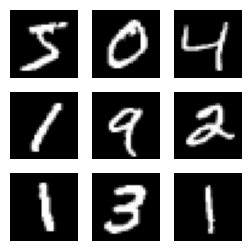

In [34]:
num_images = 9
images_per_row = 3

plt.figure(figsize=(3, 3))

for i in range(num_images):
    plt.subplot(3, images_per_row, i + 1)
    image = df.iloc[i, :-1].values.reshape(28, 28)
    plt.imshow(image, cmap="gray")

    plt.axis('off')

plt.show()

## Random Forest classifier

- model training

In [35]:
rdm_f = RandomForestClassifier()
rdm_f.fit(X_train, y_train)

y_pred_rdm = rdm_f.predict(X_test)

- counting accuracy

In [88]:
rdm_f_acc = accuracy_score(y_test, y_pred_rdm)
print(f'Accuracy: {rdm_f_acc}')

Accuracy: 0.968


- confusion matrix

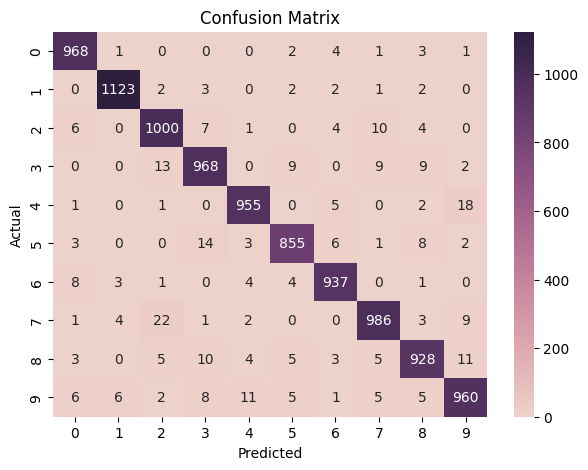

In [37]:
cm = confusion_matrix(y_test, y_pred_rdm)

custom_cmap = sns.cubehelix_palette(as_cmap=True)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap=custom_cmap)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Logistic Regression

- model training

In [38]:
log = LogisticRegression(solver='lbfgs')
log.fit(X_train, y_train)

y_pred_l = log.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- counting accuracy

In [89]:
l_accuracy = accuracy_score(y_test, y_pred_l)
print(f'Accuracy: {l_accuracy}')

Accuracy: 0.9243


- confusion matrix

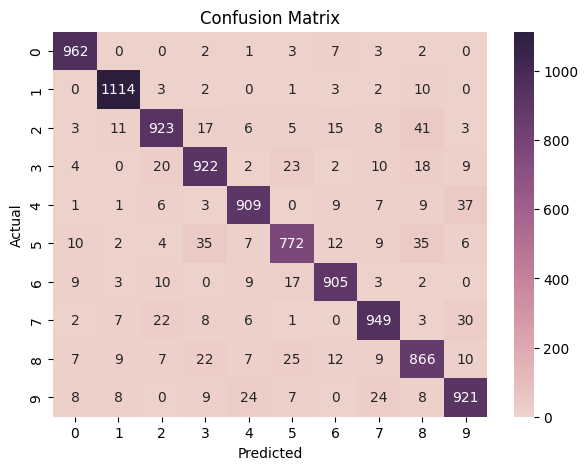

In [40]:
cm = confusion_matrix(y_test, y_pred_l)

custom_cmap = sns.cubehelix_palette(as_cmap=True)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap=custom_cmap)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## SVM

- model training

In [41]:
svm = SVC(probability=True)
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

- counting accuracy

In [90]:
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f'Accuracy: {svm_accuracy}')

Accuracy: 0.9785


- confusion matrix

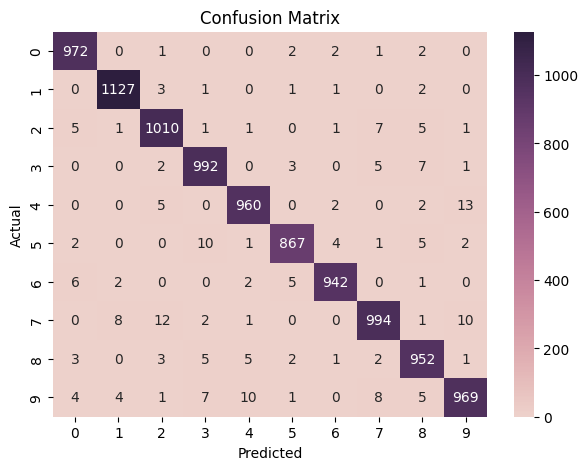

In [71]:
cm = confusion_matrix(y_test, y_pred_svm)

custom_cmap = sns.cubehelix_palette(as_cmap=True)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap=custom_cmap)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## comparing results

- accuracy

In [76]:
print(f'RandomForest accuracy:        {round(rdm_f_acc, 2)}')
print(f'Logistic Regrission accuracy: {round(l_accuracy, 2)}')
print(f'SVM accuracy:                 {round(svm_accuracy, 2)}')

RandomForest accuracy:        0.97
Logistic Regrission accuracy: 0.92
SVM accuracy:                 0.98


- ROC-curve

In [104]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = y_test_bin.shape[1]

selected_class = 0

y_score_logreg = log.decision_function(X_test)
y_score_rf = rdm_f.predict_proba(X_test)
y_score_svm = svm.decision_function(X_test)

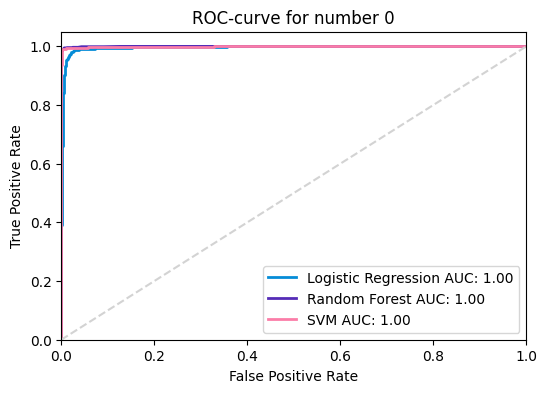

In [111]:
plt.figure(figsize=(6, 4))

# log regression roc curve
fpr_logreg, tpr_logreg, _ = roc_curve(y_test_bin[:, selected_class], y_score_logreg[:, selected_class])
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)
plt.plot(fpr_logreg, tpr_logreg, lw=2, label=f'Logistic Regression AUC: {roc_auc_logreg:.2f}', color='#058cd7')

# random forest roc curve
fpr_rf, tpr_rf, _ = roc_curve(y_test_bin[:, selected_class], y_score_rf[:, selected_class])
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, lw=2, label=f'Random Forest AUC: {roc_auc_rf:.2f}', color='#552cb7')

# svm roc curve
fpr_svm, tpr_svm, _ = roc_curve(y_test_bin[:, selected_class], y_score_svm[:, selected_class])
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.plot(fpr_svm, tpr_svm, lw=2, label=f'SVM AUC: {roc_auc_svm:.2f}', color='#fb7da8')

plt.plot([0, 1], [0, 1], linestyle='--', color='lightgray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC-curve for number {selected_class}')
plt.legend(loc="lower right")
plt.show()

As you can see, models are trained quite well!


## Voting Classifier

- gathering models and thaining

In [72]:
v_clf = VotingClassifier(
    estimators=[('rdm_f', rdm_f), ('log', log), ('svm', svm)],
    voting='soft')

v_clf.fit(X_train, y_train)

y_pred_v = v_clf.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- counting accuracy

In [73]:
v_accuracy = accuracy_score(y_test, y_pred_v)
print(v_accuracy)

0.9702


- confusion matrix

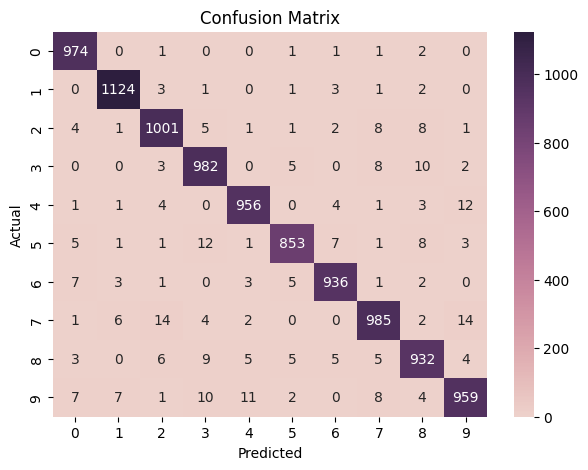

In [74]:
cm = confusion_matrix(y_test, y_pred_v)

custom_cmap = sns.cubehelix_palette(as_cmap=True)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap=custom_cmap)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## stacking models and training meta-model

- gathering the results of base-level models on validation set

In [75]:
val_pred_rf = rdm_f.predict(X_val)
val_pred_log = log.predict(X_val)
val_pred_svm = svm.predict(X_val)

- training meta-model on new features

In [78]:
# new features for meta-model on validation set
X_val_stack = np.column_stack((val_pred_rf, val_pred_log, val_pred_svm))

# training meta-model
meta_m = LogisticRegression()
meta_m.fit(X_val_stack, y_val)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

- testing meta-model on train set



In [79]:
# testing the chain we got
train_pred_rf = rdm_f.predict(X_train)
train_pred_log = log.predict(X_train)
train_pred_svm = svm.predict(X_train)

In [80]:
# new features for meta-model on train set
X_train_stack = np.column_stack((train_pred_rf, train_pred_log,
                                 train_pred_svm))

y_pred_train = meta_m.predict(X_train_stack)

## results!

- counting accuracy

In [82]:
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f'Accuracy of Meta-Model: {train_accuracy}')

Accuracy of Meta-Model: 0.9757


- confusion matrix

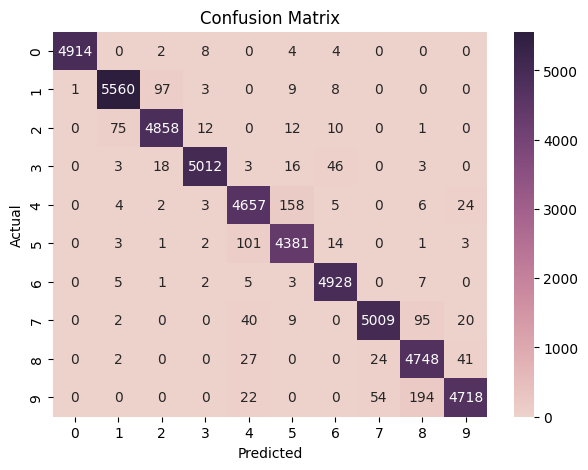

In [85]:
cm = confusion_matrix(y_train, y_pred_train)

custom_cmap = sns.cubehelix_palette(as_cmap=True)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap=custom_cmap)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Thanks for attention!